# Movie Rating Prediction Notebook

In [74]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as pxnbformat
import plotly.graph_objects as go
import plotly.io as pio
import nbformat
from plotly.subplots import make_subplots
from IPython.display import display, HTML, Image
from importlib import reload
from matplotlib_venn import venn2

# Configure plotting settings
plt.style.use('default')  # Using default matplotlib style
sns.set_theme()  # Set seaborn theme properly
plt.rcParams['figure.figsize'] = [12, 6]
pio.renderers.default = "notebook"

# Add the backend directory to Python path
current_dir = os.path.dirname(os.path.abspath(''))
backend_dir = os.path.join(current_dir, 'backend')
if backend_dir not in sys.path:
    sys.path.append(backend_dir)

# Import and reload predictor module to get latest changes
try:
    import predictor
    reload(predictor)
    from predictor import MovieRatingPredictor
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Searching in paths: {sys.path}")
    sys.exit(1)

# Initialize predictor
predictor = MovieRatingPredictor()

## Dataset Analysis

First, let's analyze our datasets using the `describe()` method from our predictor class.

In [75]:
# Get dataset description
description = predictor.describe()

if description:
    print("=== Dataset Statistics ===")
    print("-" * 50)
    for dataset_name, stats in description['dataset_statistics'].items():
        print(f"\n{stats['name']}:")
        print(f"Number of rows: {stats['rows']:,}")
        print(f"Number of columns: {stats['columns']}")
        print(f"Size in MB: {stats['size_mb']:.2f}")
        
    print("\n=== Data Sources ===")
    print("-" * 50)
    for source_name, info in description['data_sources'].items():
        print(f"\n{info['source']}:")
        print(f"Description: {info['description']}")
        print(f"URL: {info['url']}")
else:
    print("Error: Could not retrieve dataset description")

=== Dataset Statistics ===
--------------------------------------------------

IMDb Movies:
Number of rows: 5,043
Number of columns: 28
Size in MB: 1.42

TMDB Movies:
Number of rows: 45,466
Number of columns: 24
Size in MB: 32.85

=== Data Sources ===
--------------------------------------------------

IMDb Movies Dataset:
Description: Contains detailed movie information including ratings and metadata
URL: https://www.kaggle.com/code/aditimulye/imdb-5000-movie-dataset-analysis

TMDB 45K Movies Dataset:
Description: Contains comprehensive movie information including budget, revenue, and detailed metadata
URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data?select=movies_metadata.csv


In [76]:
# Debug: Print the structure of the description dictionary in a readable format
if description:
    print("=== Description Dictionary Structure ===")
    print("\nAvailable keys:", ", ".join(description.keys()))
    
    def print_nested_dict(d, indent=0):
        for key, value in d.items():
            if isinstance(value, dict):
                print("\n" + " " * indent + f"{key}:")
                print_nested_dict(value, indent + 4)
            else:
                if isinstance(value, list):
                    print(" " * indent + f"{key}: [")
                    for item in value:
                        print(" " * (indent + 4) + f"- {item}")
                    print(" " * indent + "]")
                else:
                    wrapped_value = str(value)
                    if len(wrapped_value) > 80:
                        wrapped_value = wrapped_value[:77] + "..."
                    print(" " * indent + f"{key}: {wrapped_value}")
    
    for key in description:
        print(f"\n{'='*20} {key} {'='*20}")
        print_nested_dict(description[key])
        print()
else:
    print("No description data available")

=== Description Dictionary Structure ===

Available keys: dataset_statistics, data_sources, erd

==================== dataset_statistics ====================

imdb:
    name: IMDb Movies
    rows: 5043
    columns: 28
    size_mb: 1.4206352233886719

    null_counts:
        color: 19
        director_name: 104
        num_critic_for_reviews: 50
        duration: 15
        director_facebook_likes: 104
        actor_3_facebook_likes: 23
        actor_2_name: 13
        actor_1_facebook_likes: 7
        gross: 884
        genres: 0
        actor_1_name: 7
        movie_title: 0
        num_voted_users: 0
        cast_total_facebook_likes: 0
        actor_3_name: 23
        facenumber_in_poster: 13
        plot_keywords: 153
        movie_imdb_link: 0
        num_user_for_reviews: 21
        language: 12
        country: 5
        content_rating: 303
        budget: 492
        title_year: 108
        actor_2_facebook_likes: 13
        imdb_score: 0
        aspect_ratio: 329
        movi

### Null Value Analysis

Let's visualize the null values in both datasets to better understand our data quality.

In [77]:
# Configure plotly for notebook display
import plotly.io as pio
from IPython.display import display, HTML

# Create null value visualization for both datasets
def plot_null_values(dataset_info, title):
    if 'null_counts' not in dataset_info:
        print(f"No null value information found for {title}")
        return
        
    null_data = pd.Series(dataset_info['null_counts'])
    total_rows = dataset_info['rows']
    
    # Calculate percentage of null values
    null_data_pct = (null_data / total_rows * 100).round(2)
    null_data_pct = null_data_pct[null_data_pct > 0].sort_values(ascending=True)
    
    if len(null_data_pct) > 0:
        # Create the bar plot using plotly.graph_objects for more control
        fig = go.Figure()
        
        # Add bars for null counts
        fig.add_trace(go.Bar(
            x=null_data_pct.values,
            y=null_data_pct.index,
            orientation='h',
            name='Null Percentage',
            text=[f"{v:.1f}% ({null_data[i]:,} rows)" for i, v in null_data_pct.items()],
            textposition='auto',
        ))
        
        fig.update_layout(
            title=f'Null Values in {title} (Total Rows: {total_rows:,})',
            xaxis_title='Percentage of Null Values',
            yaxis_title='Column Name',
            height=max(400, len(null_data_pct)*30),
            showlegend=False,
            xaxis=dict(range=[0, 100]),  # Set x-axis from 0 to 100%
            template='plotly_white'  # Use a clean template
        )
        
        # Convert to HTML and display
        html_str = fig.to_html(include_plotlyjs='cdn', full_html=False)
        display(HTML(html_str))
    else:
        print(f"No null values found in {title}")

print("=== Null Value Analysis ===")
print("This analysis shows the percentage of missing values in each column.\n")

# Plot null values for both datasets
if description and 'dataset_statistics' in description:
    for dataset_name, dataset_info in description['dataset_statistics'].items():
        print(f"\nAnalyzing null values in {dataset_info['name']}...")
        plot_null_values(dataset_info, dataset_info.get('name', dataset_name))
else:
    print("Error: Dataset statistics not found in description")

=== Null Value Analysis ===
This analysis shows the percentage of missing values in each column.


Analyzing null values in IMDb Movies...



Analyzing null values in TMDB Movies...


## Entity Relationship Diagram (ERD)

This will help us understand:
- The main entities in our system
- Their attributes and relationships
- The cardinality between different entities
- Primary and foreign key relationships

=== Entity Relationship Diagram ===

This diagram shows the relationships between different entities in our database:
- Boxes represent entities
- Bold attributes are Primary Keys (PK)
- Italic attributes are Foreign Keys (FK)
- Lines show relationships between entities
- Numbers (1,N) show cardinality of relationships



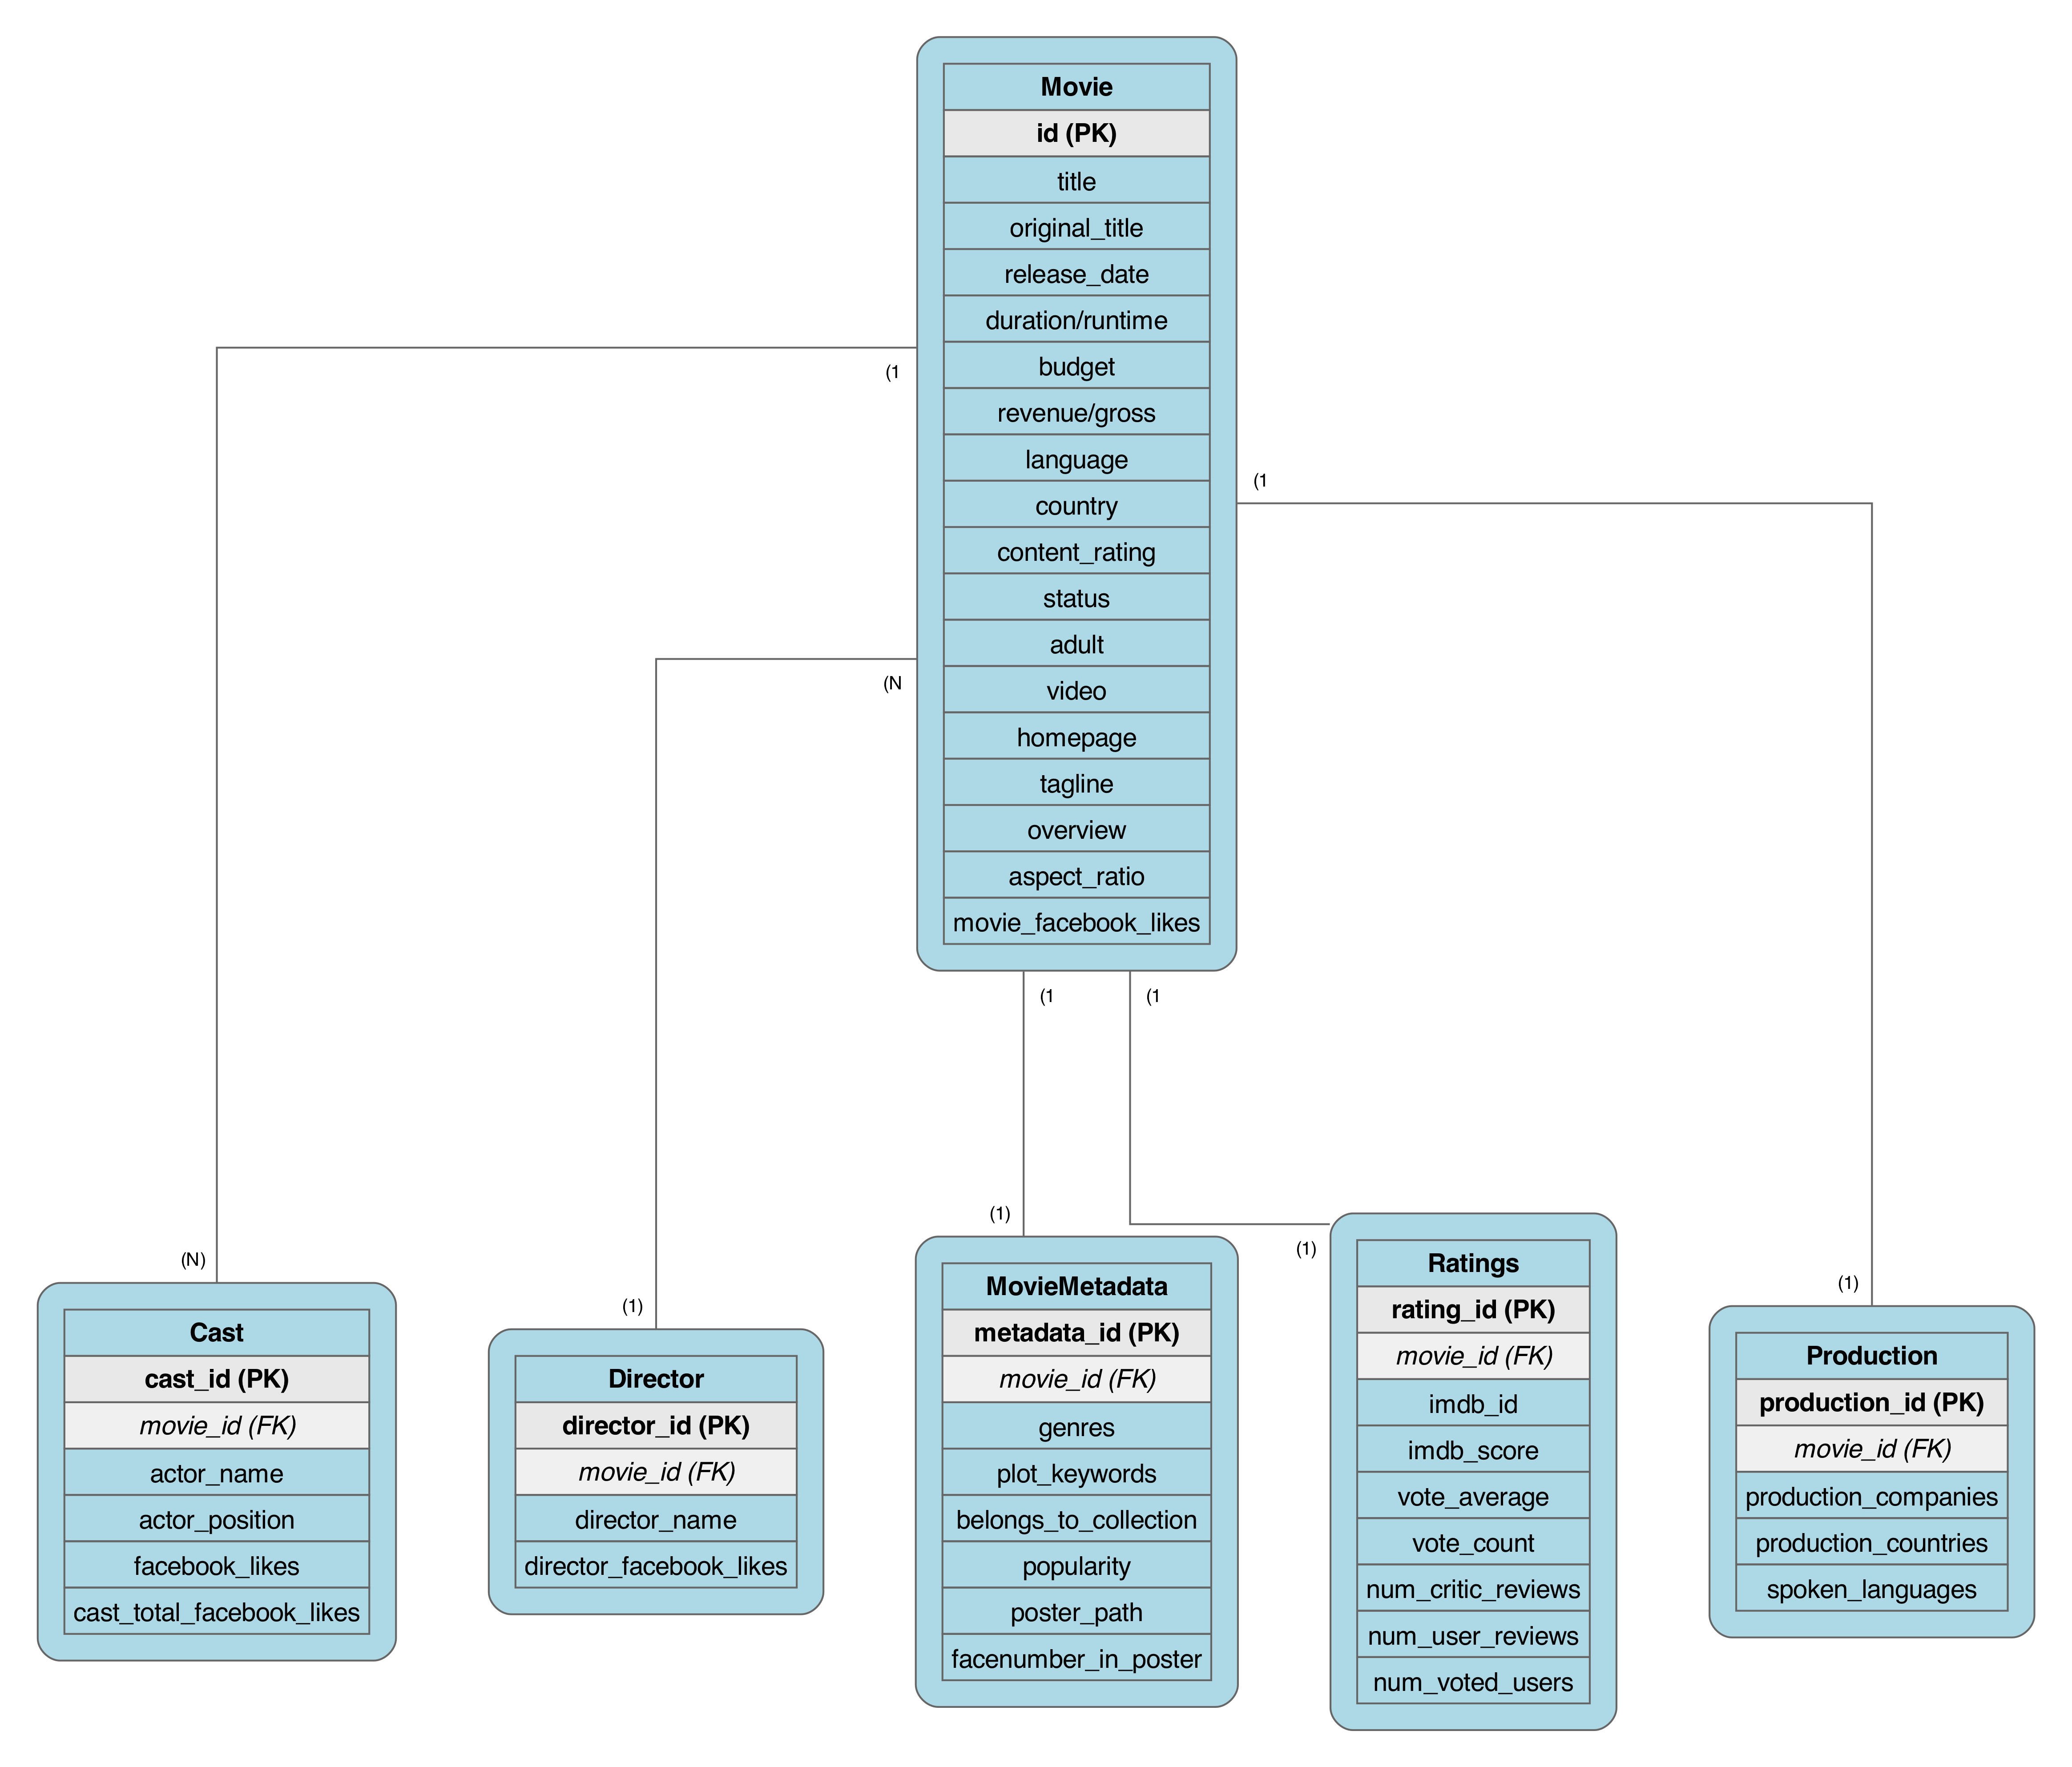

In [78]:
from graphviz import Digraph

def create_erd(erd_info):
    """Create ERD visualization using Graphviz"""
    if not erd_info:
        return "No ERD information available"
        
    # Create a new directed graph
    dot = Digraph(name='Movie Database ERD', 
                  comment='Entity Relationship Diagram for Movie Database',
                  format='png')
    
    # Graph attributes for better visualization
    dot.attr(rankdir='TB',     # Top to Bottom layout
            splines='ortho',   # Orthogonal lines
            nodesep='0.7',     # Increased spacing between nodes
            ranksep='0.9',     # Increased rank spacing
            ratio='fill')      # Fill the available space
    
    # Node attributes
    dot.attr('node', shape='box', 
            style='rounded,filled', 
            fillcolor='lightblue',
            fontname='Helvetica',
            margin='0.2',
            color='#666666')  # Lighter border color
    
    # Edge attributes
    dot.attr('edge', fontname='Helvetica',
            fontsize='10',
            color='#666666',   # Matching edge color
            minlen='2',        # Minimum edge length
            labelfloat='true', # Allow labels to float away from lines
            labeldistance='1.8',
            labelangle='45')   # Angle labels to prevent overlap

    # Create subgraph for center placement
    with dot.subgraph(name='cluster_0') as s0:
        s0.attr(rank='same', style='invis')
        # Add Movie entity in center
        entity_info = erd_info['entities']['Movie']
        label = create_entity_label('Movie', entity_info)
        s0.node('Movie', label=label)
        
    # Create subgraph for left side entities
    with dot.subgraph(name='cluster_1') as s1:
        s1.attr(rank='same', style='invis')
        # Add Cast and Director
        for entity_name in ['Cast', 'Director']:
            if entity_name in erd_info['entities']:
                label = create_entity_label(entity_name, erd_info['entities'][entity_name])
                s1.node(entity_name, label=label)

    # Create subgraph for right side entities
    with dot.subgraph(name='cluster_2') as s2:
        s2.attr(rank='same', style='invis')
        # Add MovieMetadata, Ratings, and Production
        for entity_name in ['MovieMetadata', 'Ratings', 'Production']:
            if entity_name in erd_info['entities']:
                label = create_entity_label(entity_name, erd_info['entities'][entity_name])
                s2.node(entity_name, label=label)
    
    # Add relationships with improved label placement
    for rel in erd_info['relationships']:
        entity1, cardinality = rel.split(' -- ')
        entity1 = entity1.strip('()')
        entity2 = cardinality.strip('()').split()[1]
        card_type = cardinality.split()[0]
        
        # Create edges with better label placement
        dot.edge(entity1.split()[0], entity2,
                headlabel=f' {card_type} ',     # Add spaces for better separation
                taillabel=f' {entity1.split()[1]} ',  # Add spaces for better separation
                dir='both',
                arrowhead='crow' if card_type == 'N' else 'none',
                arrowtail='none')
    
    return dot

def create_entity_label(entity_name, entity_info):
    """Helper function to create entity label with attributes"""
    label = f'<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4" COLOR="#666666">\n'
    label += f'<TR><TD PORT="header" BGCOLOR="#ADD8E6" BORDER="1"><B>{entity_name}</B></TD></TR>\n'
    for attr in entity_info['attributes']:
        if '(PK)' in attr:
            label += f'<TR><TD PORT="{attr}" BGCOLOR="#E8E8E8" BORDER="1"><B>{attr}</B></TD></TR>\n'
        elif '(FK)' in attr:
            label += f'<TR><TD PORT="{attr}" BGCOLOR="#F0F0F0" BORDER="1"><I>{attr}</I></TD></TR>\n'
        else:
            label += f'<TR><TD PORT="{attr}" BORDER="1">{attr}</TD></TR>\n'
    label += '</TABLE>>'
    return label

if description and 'erd' in description:
    print("=== Entity Relationship Diagram ===")
    print("\nThis diagram shows the relationships between different entities in our database:")
    print("- Boxes represent entities")
    print("- Bold attributes are Primary Keys (PK)")
    print("- Italic attributes are Foreign Keys (FK)")
    print("- Lines show relationships between entities")
    print("- Numbers (1,N) show cardinality of relationships\n")
    
    # Create and display ERD
    erd = create_erd(description['erd'])
    if isinstance(erd, str):
        print(erd)
    else:
        # Save in analysis directory
        analysis_dir = os.path.join(current_dir, 'analysis')
        os.makedirs(analysis_dir, exist_ok=True)
        erd_path = os.path.join(analysis_dir, 'movie_erd')

        # Render with higher DPI for better quality and landscape orientation
        erd.attr(dpi='300')
        erd.render(erd_path, format='png', cleanup=True)
        
        # Display the generated ERD
        display(Image(filename=f"{erd_path}.png"))
else:
    print("Error: ERD information not found in description")

# Testing the integrate() Method

Let's test the data integration process and analyze the merged dataset.

In [79]:
try:
    import predictor

    reload(predictor)
    from predictor import MovieRatingPredictor
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Searching in paths: {sys.path}")
    sys.exit(1)

# Configure pandas display options to show full numbers (not scientific notation)
pd.options.display.float_format = '{:,.0f}'.format

# Initialize predictor
predictor = MovieRatingPredictor()
# Get the merged dataset (OUTER JOIN)
merged_df = predictor.integrate()

if merged_df is not None:
    print("=== OUTER JOIN MERGE RESULTS ===\n")
    print(f"Total rows: {len(merged_df):,}")
    print(f"Total columns: {len(merged_df.columns):,}")
    print("\nMemory usage: {:.2f} MB".format(merged_df.memory_usage(deep=True).sum() / 1024**2))

    # Check data sources
    has_imdb = merged_df['director'].notna()
    has_tmdb = merged_df['production_companies'].notna()
    
    both = (has_imdb & has_tmdb).sum()
    imdb_only = (has_imdb & ~has_tmdb).sum()
    tmdb_only = (~has_imdb & has_tmdb).sum()
    
    print("\n=== Data Source Breakdown ===")
    print(f"  Both IMDB + TMDB: {both:,} records ({both/len(merged_df)*100:.1f}%)")
    print(f"  IMDB only:        {imdb_only:,} records ({imdb_only/len(merged_df)*100:.1f}%)")
    print(f"  TMDB only:        {tmdb_only:,} records ({tmdb_only/len(merged_df)*100:.1f}%)")

    # Display first few rows with key columns
    print("\n=== First 10 Rows (Key Columns) ===")
    key_cols = ['title', 'year', 'director', 'content_rating', 'rating', 'budget', 'gross', 'genres']
    display(merged_df[key_cols].head(10))

    # Show null percentages for matched records
    matched_df = merged_df[has_imdb & has_tmdb]
    print(f"\n=== Null % in MATCHED Records Only ({len(matched_df):,} movies) ===")
    null_pct_matched = (matched_df.isnull().sum() / len(matched_df) * 100).round(2)
    null_summary_matched = pd.DataFrame({
        'Null %': null_pct_matched[null_pct_matched > 0].sort_values(ascending=False)
    })
    if len(null_summary_matched) > 0:
        display(null_summary_matched)
    else:
        print("✓ No null values in matched records!")

    # Show column data types and nulls for entire dataset
    print("\n=== Column Data Types (Entire Dataset) ===")
    display(pd.DataFrame({
        'Data Type': merged_df.dtypes,
        'Non-Null Count': merged_df.count(),
        'Null %': (merged_df.isnull().sum() / len(merged_df) * 100).round(2)
    }).sort_values('Null %', ascending=False))
else:
    print("Error: Failed to integrate datasets")

=== OUTER JOIN MERGE RESULTS ===

Total rows: 46,231
Total columns: 27

Memory usage: 32.16 MB

=== Data Source Breakdown ===
  Both IMDB + TMDB: 5,179 records (11.2%)
  IMDB only:        499 records (1.1%)
  TMDB only:        40,518 records (87.6%)

=== First 10 Rows (Key Columns) ===


,title,year,director,content_rating,rating,budget,gross,genres
0,avatar,"2,009",James Cameron,PG-13,8,"237,000,000","1,774,235,467","[Science Fiction, Adventure, Fantasy, Sci-Fi, ..."
1,pirates of the caribbean at world's end,"2,007",Gore Verbinski,PG-13,7,"300,000,000","635,202,076","[Adventure, Fantasy, Action]"
2,spectre,"2,015",Sam Mendes,PG-13,7,"245,000,000","540,374,392","[Adventure, Crime, Thriller, Action]"
3,the dark knight rises,"2,012",Christopher Nolan,PG-13,8,"250,000,000","766,534,870","[Drama, Crime, Thriller, Action]"
4,star wars episode vii the force awakens,NaN,Doug Walker,NaN,7,NaN,NaN,[Documentary]
5,john carter,"2,012",Andrew Stanton,PG-13,6,"261,850,000","178,598,890","[Adventure, Science Fiction, Sci-Fi, Action]"
6,spiderman 3,"2,007",Sam Raimi,PG-13,6,"258,000,000","613,700,964","[Adventure, Romance, Fantasy, Action]"
7,spiderman 3,"2,007",Sam Raimi,PG-13,6,"258,000,000","613,700,964","[Adventure, Romance, Fantasy, Action]"
8,tangled,"2,010",Nathan Greno,PG,8,"260,000,000","396,301,099","[Romance, Adventure, Family, Musical, Comedy, ..."
9,tangled,"2,001",Nathan Greno,PG,7,"130,000,000","100,403,631","[Romance, Adventure, Family, Thriller, Drama, ..."



=== Null % in MATCHED Records Only (5,179 movies) ===


,Null %
aspect_ratio,4
content_rating,3
plot_keywords,1
facenumber_in_poster,0
critic_votes,0
actor_3_likes,0
actor_3,0
color,0
actor_2,0
actor_2_likes,0



=== Column Data Types (Entire Dataset) ===


,Data Type,Non-Null Count,Null %
aspect_ratio,float64,5459,88
content_rating,object,5484,88
plot_keywords,object,5649,88
director_likes,float64,5678,88
director,object,5678,88
critic_votes,float64,5763,88
color,object,5795,87
actor_3,object,5791,87
actor_3_likes,float64,5791,87
facenumber_in_poster,float64,5799,87


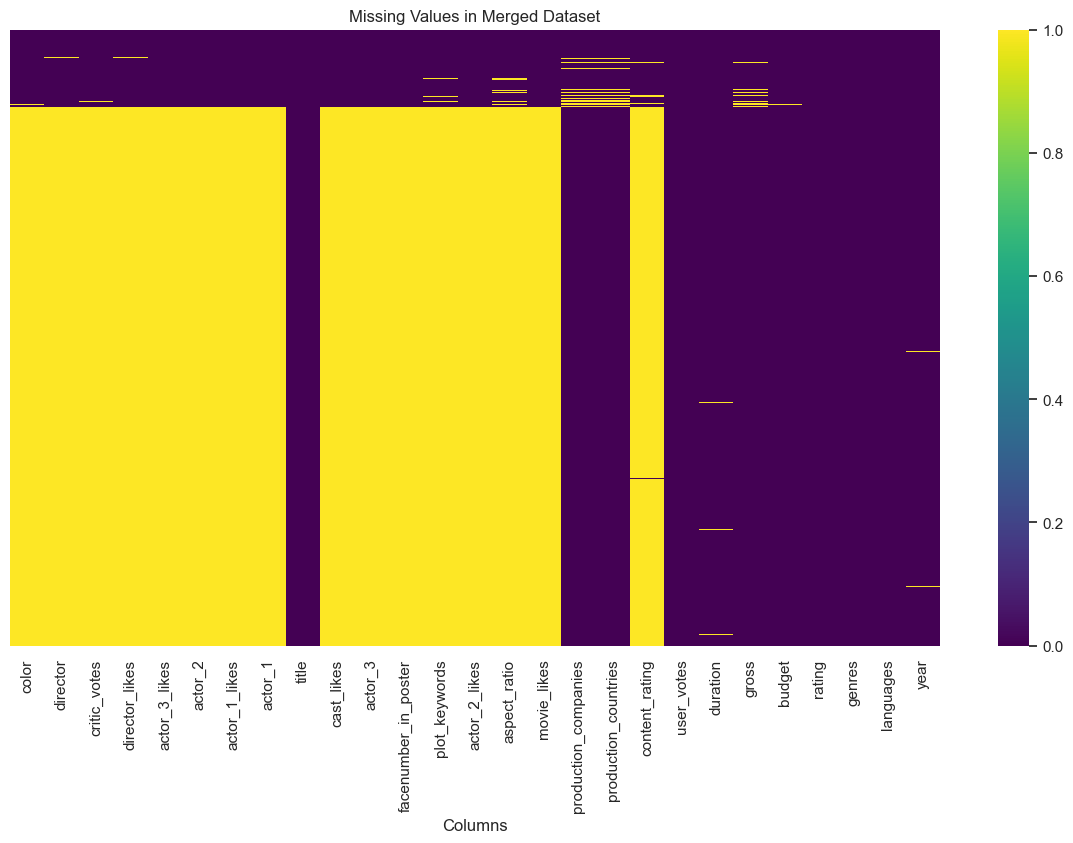

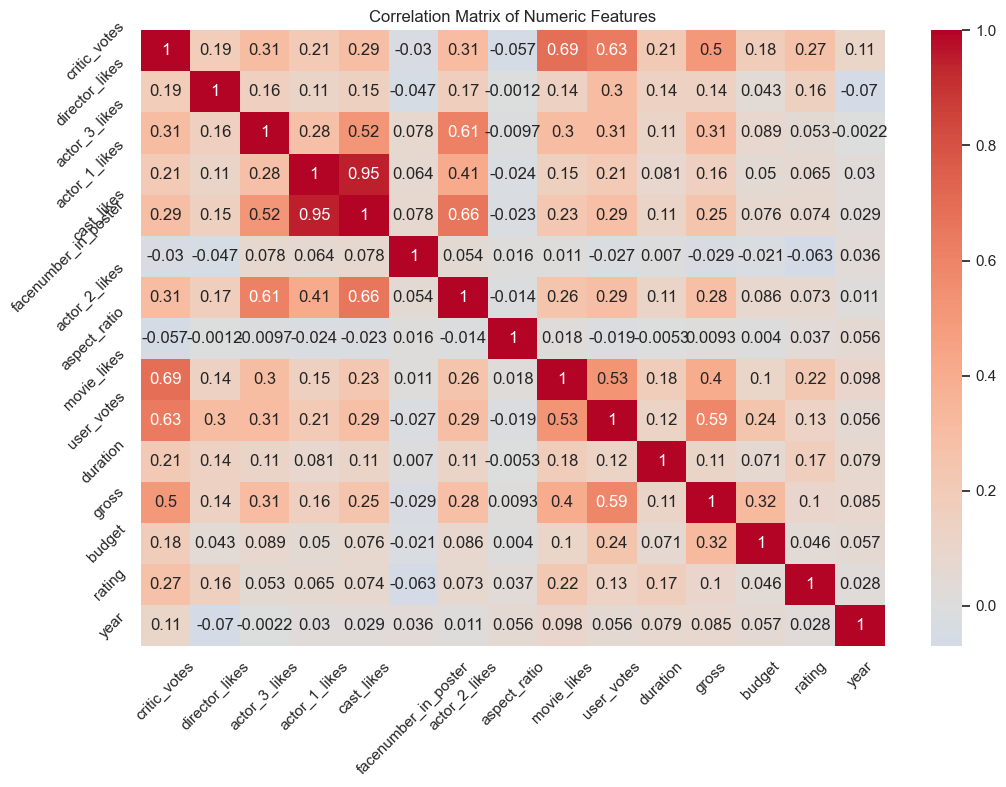

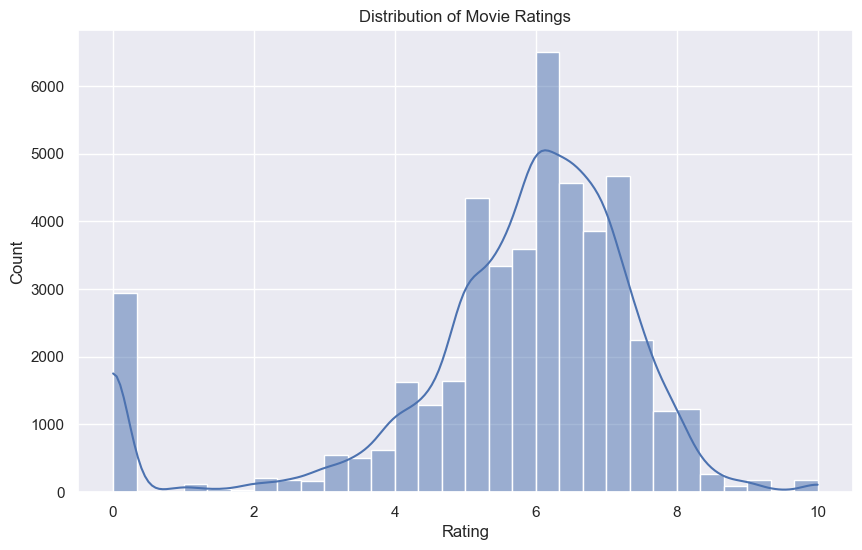

In [80]:
# Create visualizations for the merged dataset
if merged_df is not None:
    # 1. Missing values heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(merged_df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values in Merged Dataset')
    plt.xlabel('Columns')
    plt.show()
    
    # 2. Correlation matrix for numeric columns
    numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_cols) > 0:
        plt.figure(figsize=(12, 8))
        correlation_matrix = merged_df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Numeric Features')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.show()
    
    # 3. Distribution of ratings
    plt.figure(figsize=(10, 6))
    sns.histplot(data=merged_df, x='rating', bins=30, kde=True)
    plt.title('Distribution of Movie Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()
else:
    print("No visualizations created: Dataset integration failed")